# 8 CER Forest Structure Analysis Post Defense 
Standardized Depth Value (SDV) Analysis

created by Cassie Lumbrazo\
date: April 2024\
python environment: **raster**

In [3]:
# import packages 
# %matplotlib widget
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

import csv 
import copy 
import os.path 

import geopandas as gpd
# from rasterio.warp import calculate_default_transform, reproject, Resampling
# import rioxarray
# import rasterio
# import rasterstats
import scipy

In [4]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [5]:
# set seaborn plotting constants to make all the plots look good 
# sns.set_context("talk", font_scale=1)

In [6]:
# The two netcdfs created in the previous notebook, one has some correction for negative snow depth values and the other has the snow depth values cut at zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_cutatzero.nc') # for the snow depth values cut a zero
# ds = xr.open_dataset('/home/lumbraca/raster/data/rapid_model_cleandata_create_netcdf_negtozero.nc') # for the snow depth values negative to zeros
# ds.close() # how to close a dataset 

ds = xr.open_dataset('C:\\Users\\Lumbr\\OneDrive - UW/Documents\\Washington\\EasternCascades\\Python\\CER_raster_analysis\\rapid_model_cleandata_create_netcdf_negtozero_v3_b.nc') 
ds

c:\Users\Lumbr\miniconda3\envs\raster\lib\site-packages\xarray\backends\plugins.py:65: RuntimeWarning: Engine 'rasterio' loading failed:
DLL load failed while importing _base: The specified module could not be found.
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


<xarray.Dataset>
Dimensions:                           (x: 2564, y: 1388, band: 1)
Coordinates:
  * x                                 (x) float64 4.65e+05 ... 4.676e+05
  * y                                 (y) float64 2.111e+05 ... 2.097e+05
  * band                              (band) int32 1
    spatial_ref                       int32 ...
Data variables: (12/339)
    chmws_rapid                       (band, y, x) float32 ...
    dce_rapid                         (band, y, x) float32 ...
    giulia_dce_rapid                  (band, y, x) float32 ...
    giulia_dce_ncalm                  (band, y, x) float32 ...
    baf_old                           (band, y, x) float32 ...
    baf_new                           (band, y, x) float32 ...
    ...                                ...
    hs_rapid_baf_new_100s_n           (band, y, x) float32 ...
    hs_rapid_baf_new_30s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_60s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_80s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_90s_s            (band, y, x) float32 ...
    hs_rapid_baf_new_100s_s           (band, y, x) float32 ...

## Constants

In [7]:
colorpre='darkslategray'
colorpos='royalblue'
# colorpos='mediumvioletred'

colorsouth = 'darkorange'
colornorth = 'darkblue'

## Calculate SDV 
Using previous code locally, from this file: https://github.com/cassielumbrazo/RAPID_raster_analysis/blob/main/6_rapid_compare_canopy_v3.ipynb


In [8]:
# Per Justin, we should remove snow depths = 0
ds['hs_rapid_nozeros'] = ds['hs_rapid'].where(ds['hs_rapid']!=0)
ds['hs_ncalm_nozeros'] = ds['hs_ncalm'].where(ds['hs_ncalm']!=0)

# # SVD = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey
ds['sdv_rapid'] = (ds['hs_rapid'] - ds['hs_rapid'].mean(dim=['x','y'])) / ds['hs_rapid'].std(dim=['x','y'])
ds['sdv_ncalm'] = (ds['hs_ncalm'] - ds['hs_ncalm'].mean(dim=['x','y'])) / ds['hs_ncalm'].std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm'] = (ds['sdv_rapid'] - ds['sdv_ncalm'])

# We want to calculate SVD only using zero values 
# SVD = (measured snow depth at a point - the mean depth for the survey) / the standard deviation of the survey
ds['sdv_rapid_nozeros'] = (ds['hs_rapid_nozeros'] - ds['hs_rapid_nozeros'].mean(dim=['x','y'])) / ds['hs_rapid_nozeros'].std(dim=['x','y'])
ds['sdv_ncalm_nozeros'] = (ds['hs_ncalm_nozeros'] - ds['hs_ncalm_nozeros'].mean(dim=['x','y'])) / ds['hs_ncalm_nozeros'].std(dim=['x','y'])

ds['diff_sdv_rapid_ncalm_nozeros'] = (ds['sdv_rapid_nozeros'] - ds['sdv_ncalm_nozeros'])

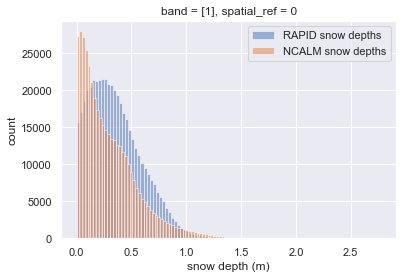

In [9]:
# Are snow depths approximately normally distributed? Per Justin, if they are not, it could throw off the SDV analysis
plt.figure();
ds['hs_rapid_nozeros'].plot.hist(bins=100,alpha=0.5, label='RAPID snow depths');
ds['hs_ncalm_nozeros'].plot.hist(bins=100,alpha=0.5, label='NCALM snow depths');
plt.legend()
plt.ylabel('count');
plt.xlabel('snow depth (m)');

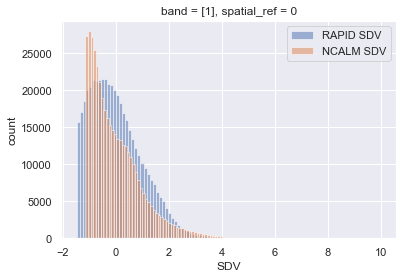

In [10]:
# Are snow depths approximately normally distributed? Per Justin, if they are not, it could throw off the SDV analysis
plt.figure();
ds['sdv_rapid_nozeros'].plot.hist(bins=100,alpha=0.5, label='RAPID SDV');
ds['sdv_ncalm_nozeros'].plot.hist(bins=100,alpha=0.5, label='NCALM SDV');
plt.legend()
plt.ylabel('count');
plt.xlabel('SDV');

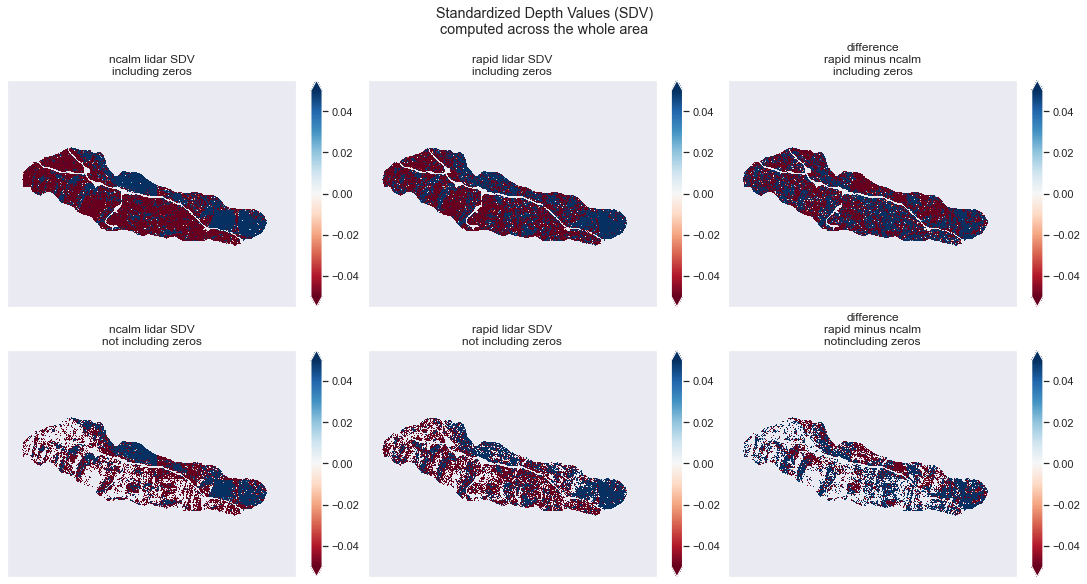

In [11]:
# plot SDV maps for ncalm and rapid and difference in SDV
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15,8), constrained_layout = True)
ds['sdv_ncalm'].plot(ax=axes[0,0], cmap='RdBu', vmin=-0, vmax=0, cbar_kwargs={'label': ''})
ds['sdv_rapid'].plot(ax=axes[0,1], cmap='RdBu', vmin=-0, vmax=0, cbar_kwargs={'label': ''})
ds['diff_sdv_rapid_ncalm'].plot(ax=axes[0,2], cmap='RdBu', vmin=-0, vmax=0, cbar_kwargs={'label': ''})

ds['sdv_ncalm_nozeros'].plot(ax=axes[1,0], cmap='RdBu', vmin=-0, vmax=0, cbar_kwargs={'label': ''})
ds['sdv_rapid_nozeros'].plot(ax=axes[1,1], cmap='RdBu', vmin=-0, vmax=0, cbar_kwargs={'label': ''})
ds['diff_sdv_rapid_ncalm_nozeros'].plot(ax=axes[1,2], cmap='RdBu', vmin=-0, vmax=0, cbar_kwargs={'label': ''})

plt.suptitle('Standardized Depth Values (SDV)\ncomputed across the whole area')
axes[0,0].set_title('ncalm lidar SDV\nincluding zeros')
axes[0,1].set_title('rapid lidar SDV\nincluding zeros')
axes[0,2].set_title('difference\nrapid minus ncalm\nincluding zeros')

axes[1,0].set_title('ncalm lidar SDV\nnot including zeros')
axes[1,1].set_title('rapid lidar SDV\nnot including zeros')
axes[1,2].set_title('difference\nrapid minus ncalm\nnotincluding zeros')

axes[0,0].set_xlabel('');axes[0,0].set_ylabel('');axes[0,0].set_xticks([]);axes[0,0].set_yticks([])
axes[0,1].set_xlabel('');axes[0,1].set_ylabel('');axes[0,1].set_xticks([]);axes[0,1].set_yticks([])
axes[0,2].set_xlabel('');axes[0,2].set_ylabel('');axes[0,2].set_xticks([]);axes[0,2].set_yticks([])

axes[1,0].set_xlabel('');axes[1,0].set_ylabel('');axes[1,0].set_xticks([]);axes[1,0].set_yticks([])
axes[1,1].set_xlabel('');axes[1,1].set_ylabel('');axes[1,1].set_xticks([]);axes[1,1].set_yticks([])
axes[1,2].set_xlabel('');axes[1,2].set_ylabel('');axes[1,2].set_xticks([]);axes[1,2].set_yticks([])

plt.show()

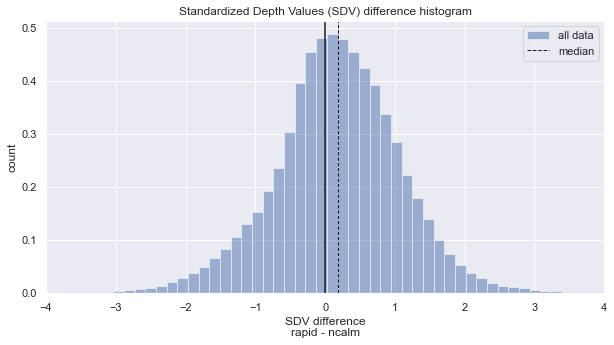

In [14]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_nozeros'].plot.hist(bins=100, alpha=0.5, density=True, label='all data');
# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].median(), color='k', linestyle='dashed', linewidth=1, label='median');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('count')
plt.xlabel('SDV difference\nrapid - ncalm')

plt.title('Standardized Depth Values (SDV) difference histogram')
plt.show()

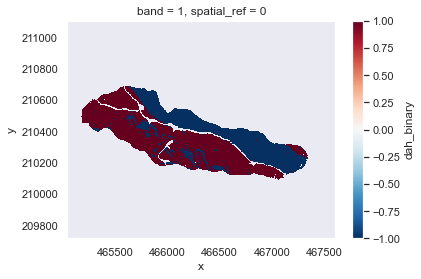

In [15]:
ds['dah_binary'].plot()

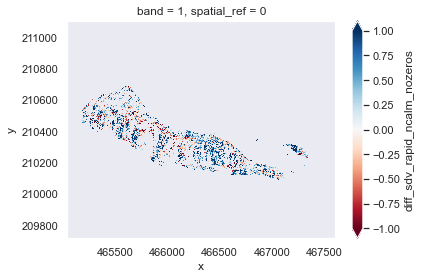

In [23]:
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['dah_binary'] ==  1).plot(cmap='RdBu', vmin=-1, vmax=1)

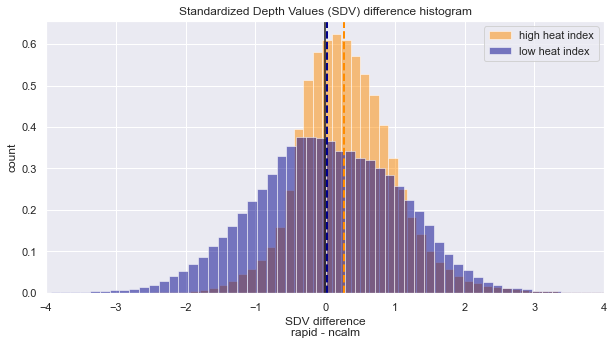

In [21]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['dah_binary'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['dah_binary'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='low heat index');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['dah_binary'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=2, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['dah_binary'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=2, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('count')
plt.xlabel('SDV difference\nrapid - ncalm')

plt.title('Standardized Depth Values (SDV) difference histogram')
plt.show()

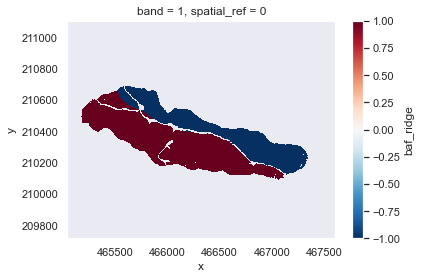

In [16]:
ds['baf_ridge'].plot()

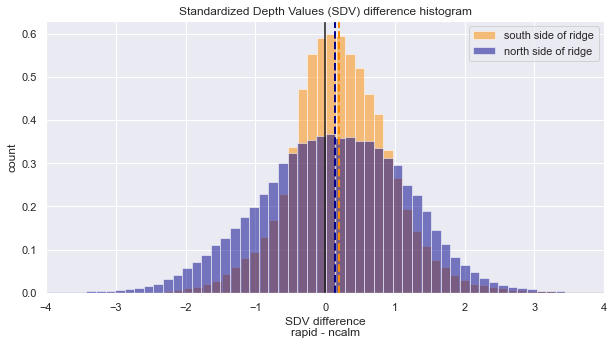

In [20]:
fig = plt.figure(figsize=(10,5))
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1).plot.hist(bins=100, color=colorsouth, alpha=0.5, density=True, label='south side of ridge');
ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1).plot.hist(bins=100, color=colornorth, alpha=0.5, density=True, label='north side of ridge');

# plot the median line 
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] ==  1).median(), color=colorsouth, linestyle='dashed', linewidth=2, label='');
plt.axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where(ds['baf_ridge'] == -1).median(), color=colornorth, linestyle='dashed', linewidth=2, label='');
plt.axvline(0,c='k')

# constants
# plt.legend(loc=(1.02,.5));
plt.legend()

plt.xlim(-4,4);
plt.ylabel('count')
plt.xlabel('SDV difference\nrapid - ncalm')

plt.title('Standardized Depth Values (SDV) difference histogram')
plt.show()

Text(0.5, 1.0, 'north side of ridge')

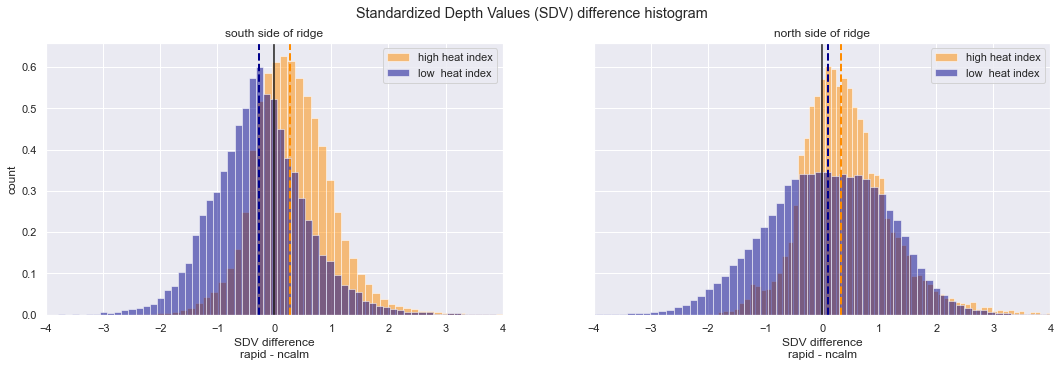

In [37]:
fig, axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18,5))
ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[0], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).plot.hist(ax=axes[0], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');
ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).plot.hist(ax=axes[1], bins=100, color=colorsouth, alpha=0.5, density=True, label='high heat index');
ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).plot.hist(ax=axes[1], bins=100, color=colornorth, alpha=0.5, density=True, label='low  heat index');

# plot the median line 
axes[0].axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=2, label='');
axes[0].axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  1)  & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=2, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] ==  1)).median(), color=colorsouth, linestyle='dashed', linewidth=2, label='');
axes[1].axvline(ds['diff_sdv_rapid_ncalm_nozeros'].where((ds['baf_ridge'] ==  -1) & (ds['dah_binary'] == -1)).median(), color=colornorth, linestyle='dashed', linewidth=2, label='');

axes[0].axvline(0,c='k');axes[1].axvline(0,c='k')

# constants
# axes[0].legend(loc=(1.02,.5));
axes[0].legend()
axes[1].legend()

axes[0].set_xlim(-4,4);
axes[0].set_ylabel('count')
axes[0].set_xlabel('SDV difference\nrapid - ncalm')
axes[1].set_xlabel('SDV difference\nrapid - ncalm')

plt.suptitle('Standardized Depth Values (SDV) difference histogram')
axes[0].set_title('south side of ridge')
axes[1].set_title('north side of ridge')